In [1]:
import sys
import os
import pandas as pd
import numpy as np
import scipy
from scipy import stats
from importlib import reload
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import csr_matrix
import glob
import pyBigWig
import scanpy as sc 

import warnings
warnings.simplefilter("ignore", category=RuntimeWarning)

# local imports
source_path = os.path.abspath("utilities/")
sys.path.append(source_path)
import utils as ut
import plotting as plt2
import matrix as matrix
import centrality as central
import curvature as curv

# hyperlocal imports
import core_utils

In [2]:
reload(core_utils)
# load chromsizes 
fpath = "/nfs/turbo/umms-indikar/shared/projects/poreC/pipeline_outputs/higher_order/reference/chrom_sizes.csv"
chroms = core_utils.load_chrom_sizes(fpath)
chrom_starts = dict(zip(chroms['chrom'].values, chroms['bp_start'].values))
chroms.head()

,chrom,size,bp_start
0,1,195154279,0
1,2,181755017,195154279
2,3,159745316,376909296
3,4,156860686,536654612
4,5,151758149,693515298


# Load Data

In [3]:
%%time 
resolution = 1000000
chrom = "chr2"

dpath = "/nfs/turbo/umms-indikar/shared/projects/poreC/pipeline_outputs/higher_order/by_chromosome/"

file_list = sorted(glob.glob(f"{dpath}population*_{resolution}_{chrom}*"))
fpath = file_list[0]

adata = sc.read_h5ad(fpath)
sc.logging.print_memory_usage()
adata

Memory usage: current 0.94 GB, difference +0.94 GB
CPU times: user 1.05 s, sys: 249 ms, total: 1.29 s
Wall time: 1.53 s


AnnData object with n_obs × n_vars = 179 × 186499
    obs: 'bin_index', 'bin_start', 'bin_end', 'bin', 'chrom', 'chrom_bin', 'degree', 'genes', 'n_genes', 'ATACSeq_1', 'ATACSeq_2', 'ATACSeq_3', 'CTCF', 'H3K27ac', 'H3K27me3', 'RNA_1', 'RNA_2', 'RNA_3', 'RNA_4', 'RNA_5', 'RNA_6', 'PolII', 'chrom_degree'
    var: 'read_index', 'basename', 'mean_mapq', 'median_mapq', 'n_chromosomes', 'order', 'n_bins', 'read_length_bp', 'genes', 'n_genes', 'chrom_order'
    uns: 'base_resolution', 'chrom_sizes', 'gene_map'

# Make incidence

In [4]:
%%time
H = adata.to_df().copy()
H = H.T.drop_duplicates().T
print(f"{H.shape=}")

H.head()

H.shape=(179, 55574)
CPU times: user 1.32 s, sys: 374 ms, total: 1.69 s
Wall time: 1.73 s


read_name,3db453c3-be68-417e-bf3f-7d660af7d1aa,2e567d50-8451-4643-a981-1cd91a0062c0,32e53ef8-c394-4db7-bb72-e29a3281a26f,3b0686b6-f18f-495d-89f5-8c8b286c2bb1,ef7ff38e-a5fe-4692-b270-9a704ffa2981,b079fedb-5786-48f4-a0f4-f0e72b85a88f,dc63595a-de81-4976-b052-4f514babc44a,b40b53f2-eb37-4ab7-81c8-ba08d8fd43eb,c7e3608d-c42b-4c51-a1be-c8944d9746a5,b0e7292e-f949-46dc-b91c-7efa75d6f52c,...,e97c0c28-5407-4742-8fec-8e780ef16ac5,9985b821-95d0-40ac-bf49-5a8e03b436b7,96d1ecba-d4cb-49ba-8537-6832844719f4,8ad4327b-37f3-4ebd-9ce1-1fbcbe4d7212,17b55753-fb2e-4320-b395-31e11b192b6d,568f633f-87c9-423b-8a9a-46db831240da,9d60a236-f96b-44d2-ae0e-62e35e182171,58d4fde0-ab55-4bd0-b352-263e95568aa1,8b9fc952-041f-4259-9345-e5a7bca01533,6773fcdb-ce91-4679-8197-6e50b4a20d54
bin_name,,,,,,,,,,,,,,,,,,,,,
chr2:3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
chr2:4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
chr2:5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
chr2:6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
chr2:7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Eigenvector Centrality (Edges)

In [12]:
%%time

node_ev, edge_ev = central.nonlinear_eigenvector_centrality(
    H, 
    function='log-exp', 
    maxiter=100000,
)

df = pd.DataFrame({
    'read_name' : H.columns,
    'ev' : list(edge_ev),
    'ev_zscore': stats.zscore(edge_ev),
    'ev_norm': ut.min_max(edge_ev),  # Assuming you have ut.min_max elsewhere
})

df.head()

CPU times: user 298 ms, sys: 13.4 ms, total: 311 ms
Wall time: 335 ms


,read_name,ev,ev_zscore,ev_norm
0,3db453c3-be68-417e-bf3f-7d660af7d1aa,7.217661e-05,1.791314,0.991177
1,2e567d50-8451-4643-a981-1cd91a0062c0,6.980129e-05,1.712784,0.958558
2,32e53ef8-c394-4db7-bb72-e29a3281a26f,4.034022e-07,-0.581558,0.005540
3,3b0686b6-f18f-495d-89f5-8c8b286c2bb1,7.272485e-05,1.809439,0.998706
4,ef7ff38e-a5fe-4692-b270-9a704ffa2981,6.943321e-05,1.700615,0.953503


# Add Curvature

In [13]:
%%time

Hlist = ut.incidence_to_list_of_list(H)
print(f"{len(Hlist)=}")

hlrc = curv.compute_hlrc(Hlist)
print(f"{len(hlrc)=}")

# add edge curvature to dataframe
df['hlrc'] = hlrc
df.head()

len(Hlist)=55574
len(hlrc)=55574
CPU times: user 1.35 s, sys: 3.55 ms, total: 1.36 s
Wall time: 1.39 s


,read_name,ev,ev_zscore,ev_norm,hlrc
0,3db453c3-be68-417e-bf3f-7d660af7d1aa,7.217661e-05,1.791314,0.991177,1.000000
1,2e567d50-8451-4643-a981-1cd91a0062c0,6.980129e-05,1.712784,0.958558,1.000000
2,32e53ef8-c394-4db7-bb72-e29a3281a26f,4.034022e-07,-0.581558,0.005540,0.994366
3,3b0686b6-f18f-495d-89f5-8c8b286c2bb1,7.272485e-05,1.809439,0.998706,1.000000
4,ef7ff38e-a5fe-4692-b270-9a704ffa2981,6.943321e-05,1.700615,0.953503,0.994382


In [7]:
adata.var.head()

,read_index,basename,mean_mapq,median_mapq,n_chromosomes,order,n_bins,read_length_bp,genes,n_genes,chrom_order
read_name,,,,,,,,,,,
3db453c3-be68-417e-bf3f-7d660af7d1aa,23,batch03,43.500000,60.0,3,6,4,3971,Taf4;Ccnd3,2,2
2e567d50-8451-4643-a981-1cd91a0062c0,50,batch04,31.000000,31.0,1,4,2,7193,Zfp385b,1,2
32e53ef8-c394-4db7-bb72-e29a3281a26f,89,batch01,48.714286,60.0,7,14,12,6617,Prex1;Gfod1;Zfp385c;Cdk5rap2;Pcbp3;Kif16b;Fbxl...,10,3
3b0686b6-f18f-495d-89f5-8c8b286c2bb1,98,batch04,54.045455,60.0,5,22,11,10686,Fmnl2;Runx1;Robo1;Dyrk1a;Gm30695;Senp7;Atp5po,7,2
ef7ff38e-a5fe-4692-b270-9a704ffa2981,129,batch03,59.500000,60.0,5,10,6,7913,Ttyh2;Birc6;Gm26749;Dll4,4,2


In [8]:
df.head()

,read_name,ev,ev_zscore,ev_norm,hlrc
0,3db453c3-be68-417e-bf3f-7d660af7d1aa,0.000056,1.555319,0.827118,1.000000
1,2e567d50-8451-4643-a981-1cd91a0062c0,0.000002,-0.646359,0.014554,1.000000
2,32e53ef8-c394-4db7-bb72-e29a3281a26f,0.000057,1.586775,0.838727,0.994366
3,3b0686b6-f18f-495d-89f5-8c8b286c2bb1,0.000056,1.561588,0.829432,1.000000
4,ef7ff38e-a5fe-4692-b270-9a704ffa2981,0.000002,-0.664691,0.007789,0.994382


<Axes: xlabel='ev_zscore', ylabel='hlrc'>

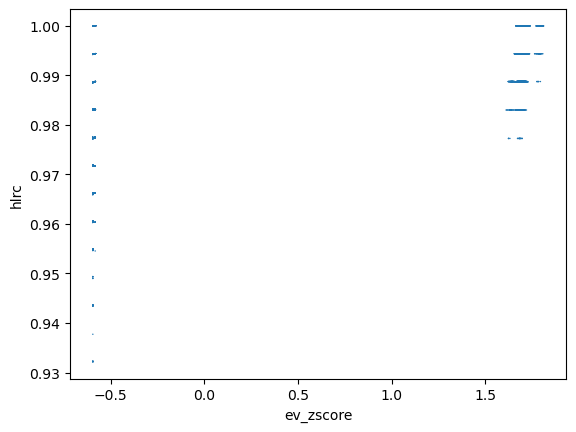

In [14]:
sns.scatterplot(
    data=df, 
    x='ev_zscore',
    y='hlrc',
    s=1,
    ec='none',
)

In [9]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)